# Grid by number simulation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import segmenteverygrain.interactions as si
import skimage
from tqdm import tqdm
%matplotlib inline

2025-06-01 15:44:12.231195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748817852.242590   28000 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748817852.246040   28000 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-01 15:44:12.257981: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load data

Images can be loaded in most common formats.

Grain information is saved as a .geojson file generated by this or other scripts.

In [2]:
# Load image
fn = 'examples/torrey_pines.jpg'
image = si.load_image(fn)

In [3]:
# Load grains
fn = './examples/auto/torrey_pines_grains.geojson'
grains = si.load_grains(fn, image=image)

### Grid count

Generate a grid with a given spacing between points, then find the grain that contains each point (if any).

By default, `filter_grains_by_points` will return one instance of a grain for every grid point that falls on it, potentially resulting in duplicates. Set `unique=True` to remove duplicates. 

In [4]:
# Define grid spacing (in pixels)
spacing_m = 0.05                    # m
px_per_m = 3390.                    # px/m
spacing_px = px_per_m * spacing_m   # px

# Generate grid
points, xs, ys = si.make_grid(image, spacing_px)
print(f'Grid contains {len(points)} points with '
      + f'{spacing_px} px ({spacing_m} m) spacing.\n')

# Find grains according to grid
grains, points_found = si.filter_grains_by_points(
    grains, points, unique=False)
n_grains = len(grains)
print(f'Found {n_grains} total grains '
      + f'({n_grains - len(set(grains))} duplicates).\n')

# Measure detected grains
for g in tqdm(grains, desc='Measuring detected grains'):
    g.measure()

Grid contains 48 points with 169.5 px (0.05 m) spacing.

Found 33 total grains (0 duplicates).



Measuring detected grains: 100%|██████████| 33/33 [00:00<00:00, 853.58it/s]


### Results

First, visualize the generated grid and detected grains:

Drawing grains: 100%|██████████| 33/33 [00:00<00:00, 119.56it/s]


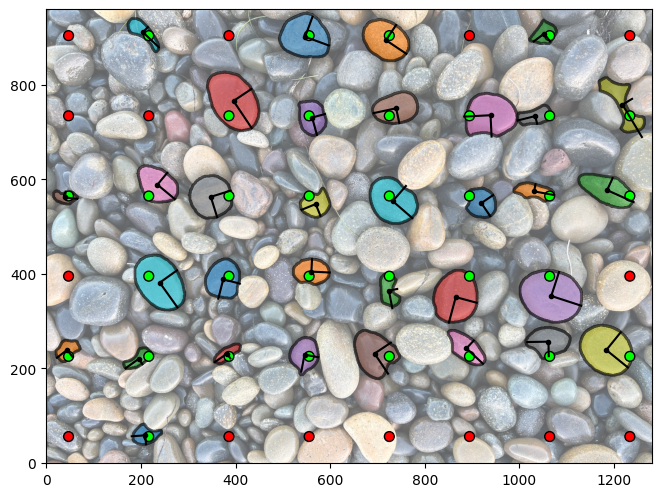

In [5]:
# Downscale image if needed
scale = 1.
max_size = np.asarray((1920, 1920))
if image.shape[0] > max_size[0] or image.shape[1] > max_size[1]:
    scale = np.min(max_size / image.shape[:2])
    image = skimage.transform.rescale(
        image, scale, anti_aliasing=False, channel_axis=2)

# Make results plot
fig = plt.figure()
ax = fig.add_subplot()

# Add image to plot
ax.imshow(image, aspect='equal', origin='lower', alpha=0.6)
ax.autoscale(enable=False)
fig.tight_layout(pad=0)

# Add grains
for grain in tqdm(grains, desc='Drawing grains'):
    grain.draw_patch(ax, scale)
    grain.draw_axes(ax, scale)

# Add grid points
ax.scatter(xs * scale, ys * scale,
    s = min(image[:2].shape) * fig.dpi / 4,
    c = ['lime' if p else 'red' for p in points_found],
    edgecolors = 'black');

Then, the following results are then saved to the location specified in `out_fn`:
- Grain shapes, for use elsewhere (geojson)
- Image with grid points displayed and counted grains highlighted (jpg)
- Summary data, presenting measurements for each detected grain (csv)
- Summary histogram, representing major/minor axes of detected grains (jpg)

In [6]:
# Save results
out_fn = 'examples/grid_count/torrey_pines'
# Grain shapes
si.save_grains(out_fn + '_grains.geojson', grains)
# Grain image
fig.savefig(out_fn + '_grains.jpg', bbox_inches='tight', pad_inches=0)
# Summary data
summary = si.save_summary(out_fn + '_summary.csv', grains, px_per_m=px_per_m)
# Summary histogram
si.save_histogram(out_fn + '_summary.jpg', summary=summary)